# Exploratory Analysis IMSS ENSAT 2017 & 2018 Primary Care

* This documents shows the exploratory analysis for the IMSS Satisfaction Surveys for the first level of attention Health Centers.
* First level of attention or Primary Care is defined as healthcare at a basic rather than specialized level for people making an initial approach to a doctor or nurse for treatment

## Has the IMSS Overall Primary Care Satisfaction grown from 2017 to 2018?
## Are there some States with higher Satisfaction?
## Which are the main Satisfaction Drivers?

## Overview

* Data Demographics
* Overall Satisfaction
* Satisfaction by Year
* Satisfaction Comparison by State
* Satisfaction KeyDrivers
* Conclusion

In [213]:
#Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from random import sample
import random
import gmaps
import folium
pd.options.display.max_seq_items = 2000
np.set_printoptions(threshold=np.nan)

# Google developer API key
from config import gkey
# Configure gmaps
gmaps.configure(api_key=gkey)

%matplotlib inline
sns.set_style(style='white')

from fstrings import f 

In [158]:
#Read Raw Data

df=pd.read_csv('DataClean\\NivelSatisf1Clean.csv',encoding='utf-8',low_memory=False)

In [159]:
# Homologates the names of MedicalUnits by merging the original data set with a new data frame with MedicalUnits unique values

df2=df[['Id_Unidad','Unidmed']]
df3=pd.DataFrame(df2.groupby('Id_Unidad').Unidmed.first())
df5=df3.reset_index()
df5=df5.rename(columns={'Unidmed':'UnidadMed'})
df6=df.merge(df5,how='left',on='Id_Unidad')

In [161]:
# Total Surveys by Year
descriptives= pd.DataFrame({'Surveys2017': [df6[df6['Fecha_A']==2017].Folio.count()],
                            'Surveys2018': [df6[df6['Fecha_A']==2018].Folio.count()],
                            'TotalSurveys': [df6.Folio.count()]
                           })

descriptives['Surveys2017']=descriptives['Surveys2017'].map(('{:,.2f}').format)
descriptives['Surveys2018']=descriptives['Surveys2018'].map(('{:,.2f}').format)
descriptives['TotalSurveys']=descriptives['TotalSurveys'].map(('{:,.2f}').format)

descriptives

,Surveys2017,Surveys2018,TotalSurveys
0,"109,531.00","122,899.00","232,430.00"


# Surveys distribution

* This section shows the surveys distribution along the Mexican Territory

In [162]:
# Build Geocoded Summary Data Frame

dfGeo=df6[['Date',
           'Entidad',
           'UnidadMed',
           'Fecha_D',
           'Fecha_M',
           'Fecha_A',
           'Servatn_cat',
           'Tipopac_cat',
           'Sat1_ordered',
           'Sat1_cat',
           'Probsal',
           'lat',
           'lng']]



encuestas=dfGeo.groupby('Entidad').Entidad.count()
latitud=dfGeo.groupby('Entidad').lat.first()
longitud=dfGeo.groupby('Entidad').lng.first()
sat=dfGeo.groupby('Entidad').Sat1_ordered.mean()

dfGeocode=pd.DataFrame({'encuestas':encuestas,
                        'lat':latitud,
                        'lon':longitud,
                        'satisf':sat                      
                       })

dfGeocode.reset_index(inplace=True)

In [163]:
# Build map with the distribution of the surveys

m = folium.Map(location=[25,-101], tiles="Mapbox Bright", zoom_start=5)
for i in range(0,len(dfGeocode)):
      folium.Circle(location=[dfGeocode.iloc[i]['lat'],dfGeocode.iloc[i]['lon']],
                    popup=(dfGeocode.iloc[i]['Entidad']),
                    radius=float(dfGeocode.iloc[i]['encuestas'])*5,
                    color='crimson',
                    fill=True,
                    fill_color='crimson'
                    ).add_to(m)
        
#Display the map
m

In [164]:
#Save the map
m.save('DataExploring\BubblemapEncuestas.html')

# Age Distribution

* This section shows the age of the people that took the survey

In [165]:
# Create age data frame

df6['Edad_cat']=df6['Edad_C'].map({1:'18-25',
                                   2:'26-34',
                                   3:'35-44',
                                   4:'45-54',
                                   5:'55-64',
                                   6:'65+'
                                  })
max_age=df6['Edad'].max()

df6['AgeBins']=pd.cut(df6['Edad'],
                       bins=[18,25,34,44,54,64,max_age+1],
                       labels=['18-25','25-34','35-44','45-54','55-64','65+'],
                       include_lowest=True,
                       right=False
                       )

byAge=df6['AgeBins'].dropna()

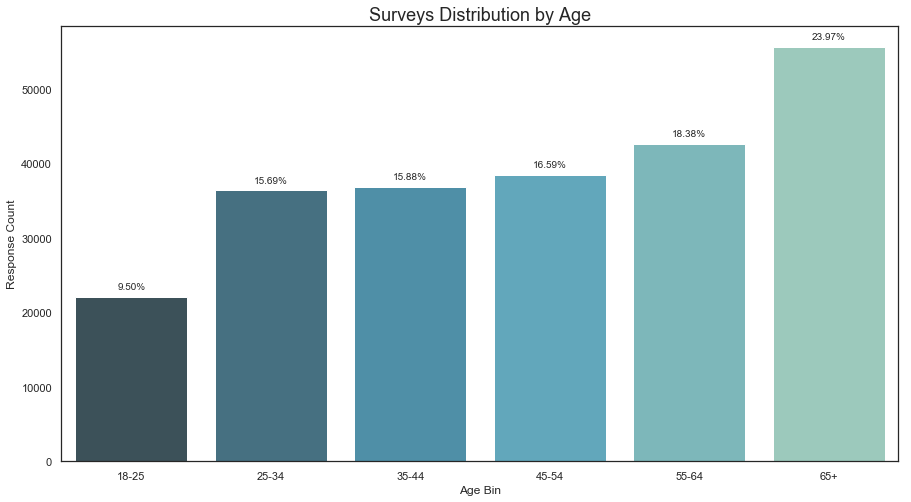

In [166]:
# Build Age plot

plt.figure(figsize=(15,8))

axAge=sns.countplot(x=byAge,palette=sns.set_palette("GnBu_d")) 


plt.xticks(rotation=0)
total = float(len(byAge)) 

for p in axAge.patches:
        
    height = p.get_height()
    axAge.text(p.get_x()+p.get_width()/2.,height+1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Surveys Distribution by Age',fontsize=18)
plt.ylabel('Response Count')
plt.xlabel('Age Bin')
plt.show()
fig=axAge.get_figure()
fig.savefig('DataExploring\\AgeDistribution.png',dpi=1200)

# Gender Distribution

* This section plots the gender distribution of the survey

In [167]:
# Map variable with categorical values

df6['Sexo_cat']=df6['Sexo'].map({1:'Mujer',
                                2:'Hombre'
                                })

In [168]:
#Build the gender count and percentage

byGender=pd.DataFrame(df6['Sexo_cat'].dropna().value_counts())
byGender['genderSize']=(byGender['Sexo_cat']/byGender['Sexo_cat'].count())*100


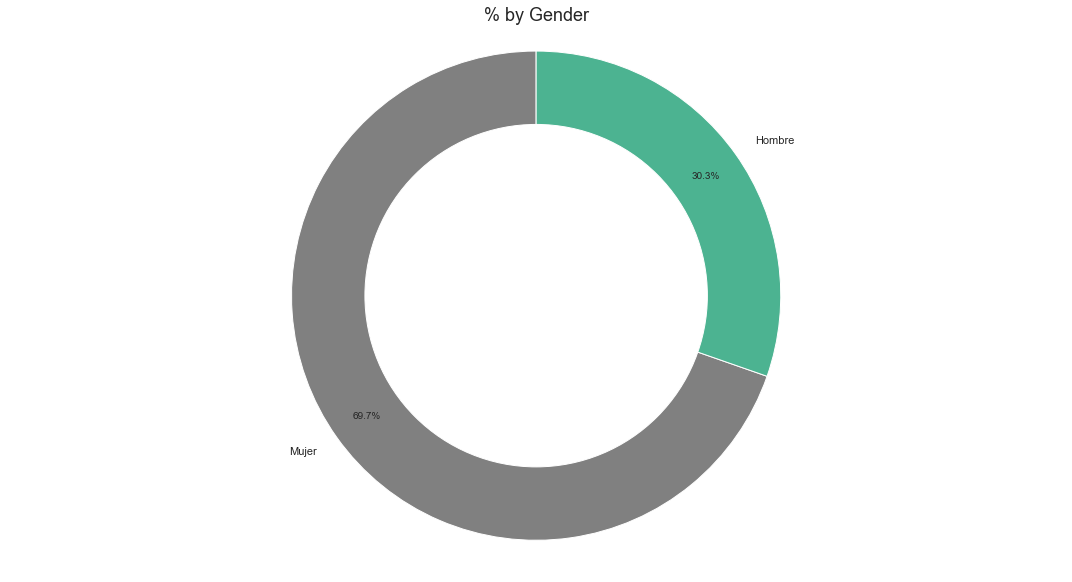

<Figure size 432x288 with 0 Axes>

In [169]:
# Build Pie Chart

plt.figure(figsize=(15,8))

gender_pie=plt.pie(x= byGender['genderSize'],
                  autopct='%1.1f%%',
                  startangle=90, 
                  pctdistance=0.85,
                  colors=('grey',"#4CB391"),
                  labels=['Mujer','Hombre'])


#draw center circle to create donut chart (this is not necesary but I think it looks cleaner)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equals the axis to ensure a circular figure

plt.tight_layout()
plt.axis('equal')
plt.title('% by Gender',fontsize=18)
plt.show()
# Save Figure
plt.savefig('DataExploring\\GenderDistribution.png',dpi=1200)

## Distribution by Education Level

### This section shows the education level distribution in the survey

In [170]:
# Build Education level categorical variable

df6['Escolar_cat']=df6['Escolar'].map({1:'Ninguno',
                                       2:'Primaria_incompleta',
                                       3:'Primaria_completa',
                                       4:'Secundaria_incompleta',
                                       5:'Secundaria_completa',
                                       6:'PreparatoriaBachilleratoTecnicoIncompleto',
                                       7:'PreparatoriaBachilleratoTecnicoCompleto',
                                       8:'UniversidadIncompleta',
                                       9:'UniversidadCompletaoMas',
                                       99: np.nan
                                      })

In [171]:
# Drop nan
byEdLevel=df6['Escolar_cat'].dropna()

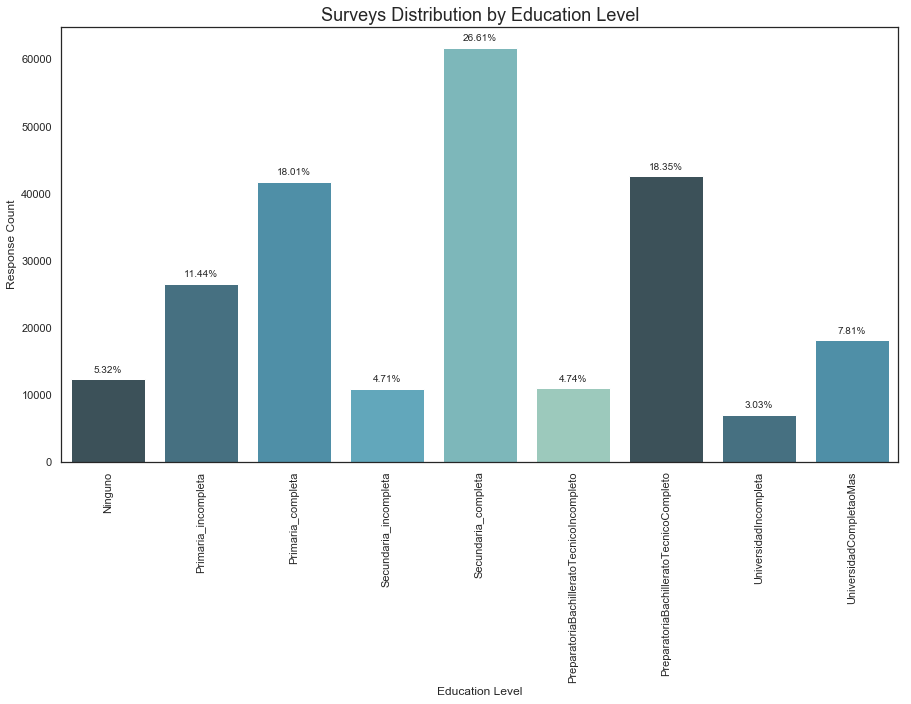

In [172]:

plt.figure(figsize=(15,8))

axEdLevel=sns.countplot(x=byEdLevel,
                        order=['Ninguno',
                               'Primaria_incompleta',
                               'Primaria_completa',
                               'Secundaria_incompleta',
                               'Secundaria_completa',
                               'PreparatoriaBachilleratoTecnicoIncompleto',
                               'PreparatoriaBachilleratoTecnicoCompleto',
                               'UniversidadIncompleta',
                               'UniversidadCompletaoMas'],
                        palette =sns.color_palette("GnBu_d")
                       )

plt.xticks(rotation=90)
total = float(len(byEdLevel)) 

for p in axEdLevel.patches:
        
    height = p.get_height()
    axEdLevel.text(p.get_x()+p.get_width()/2.,height+1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Surveys Distribution by Education Level',fontsize=18)
plt.ylabel('Response Count')
plt.xlabel('Education Level')
plt.show()
fig=axEdLevel.get_figure()
fig.savefig('DataExploring\\EdLevelDistribution.png',dpi=1200)

## Surveys Distribution by Ocupation

### This sections shows the surveys distribution by ocupation

In [173]:
# Build ocupations categorical variable

df6['Ocupa_cat']=df6['Ocupa'].map({1:'Trabajador por cuenta propia',
                                   2:'Sector privado (No maestro)',
                                   3:'Sector agropecuario',
                                   4:'Obrero',
                                   5:'Actividades de su hogar',
                                   6:'Estudiante',
                                   7:'Maestro',
                                   8:'Desempleado',
                                   9:'Pensionado o jubilado',
                                   10:'Sector público (No maestro)',
                                   11:'Trabajadora doméstica',
                                   12:'Empleado',
                                   13:'Profesionista',
                                   14:'Religioso',
                                   15:'Pescador / Marinero',
                                   16:'Incapacidad',
                                   17:'Persona con discapacidad',
                                   999:np.nan,
                                   })

# Remove na values

byOcup=df6['Ocupa_cat'].dropna()

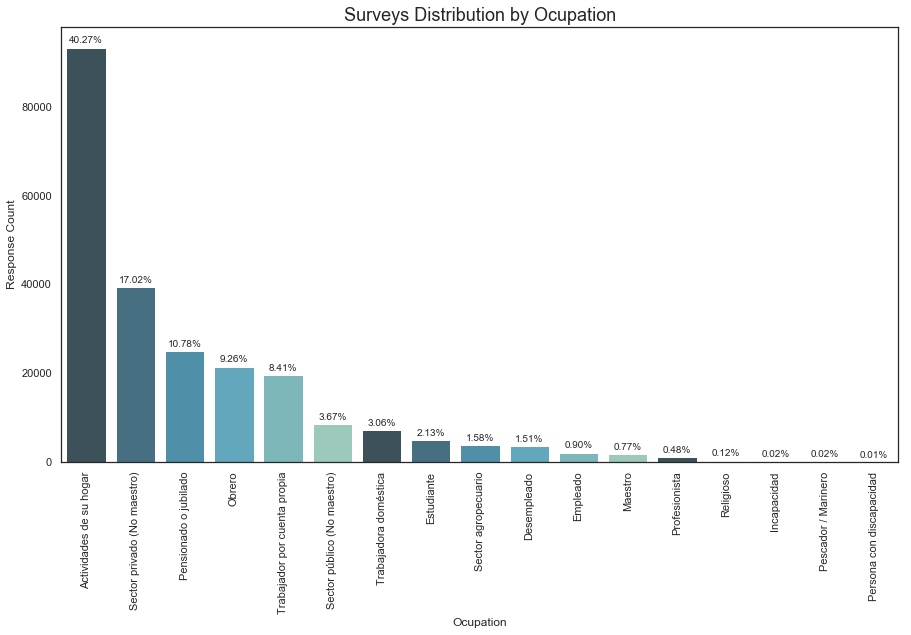

In [175]:
# Build ocupation plot

plt.figure(figsize=(15,8))
sns.set_palette("GnBu_d")

axOcup=sns.countplot(x=byOcup,order = byOcup.value_counts().index,palette =sns.color_palette("GnBu_d"))

plt.xticks(rotation=90)
total = float(len(byOcup)) 

for p in axOcup.patches:
        
    height = p.get_height()
    axOcup.text(p.get_x()+p.get_width()/2.,height+1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Surveys Distribution by Ocupation', fontsize=18)
plt.ylabel('Response Count')
plt.xlabel('Ocupation')
plt.show()
fig=axOcup.get_figure()
fig.savefig('DataExploring\\OcupationDistribution.png',dpi=1200)

# Health Problem Distribution

### This section shows the main Health Problem mentioned in the surveys

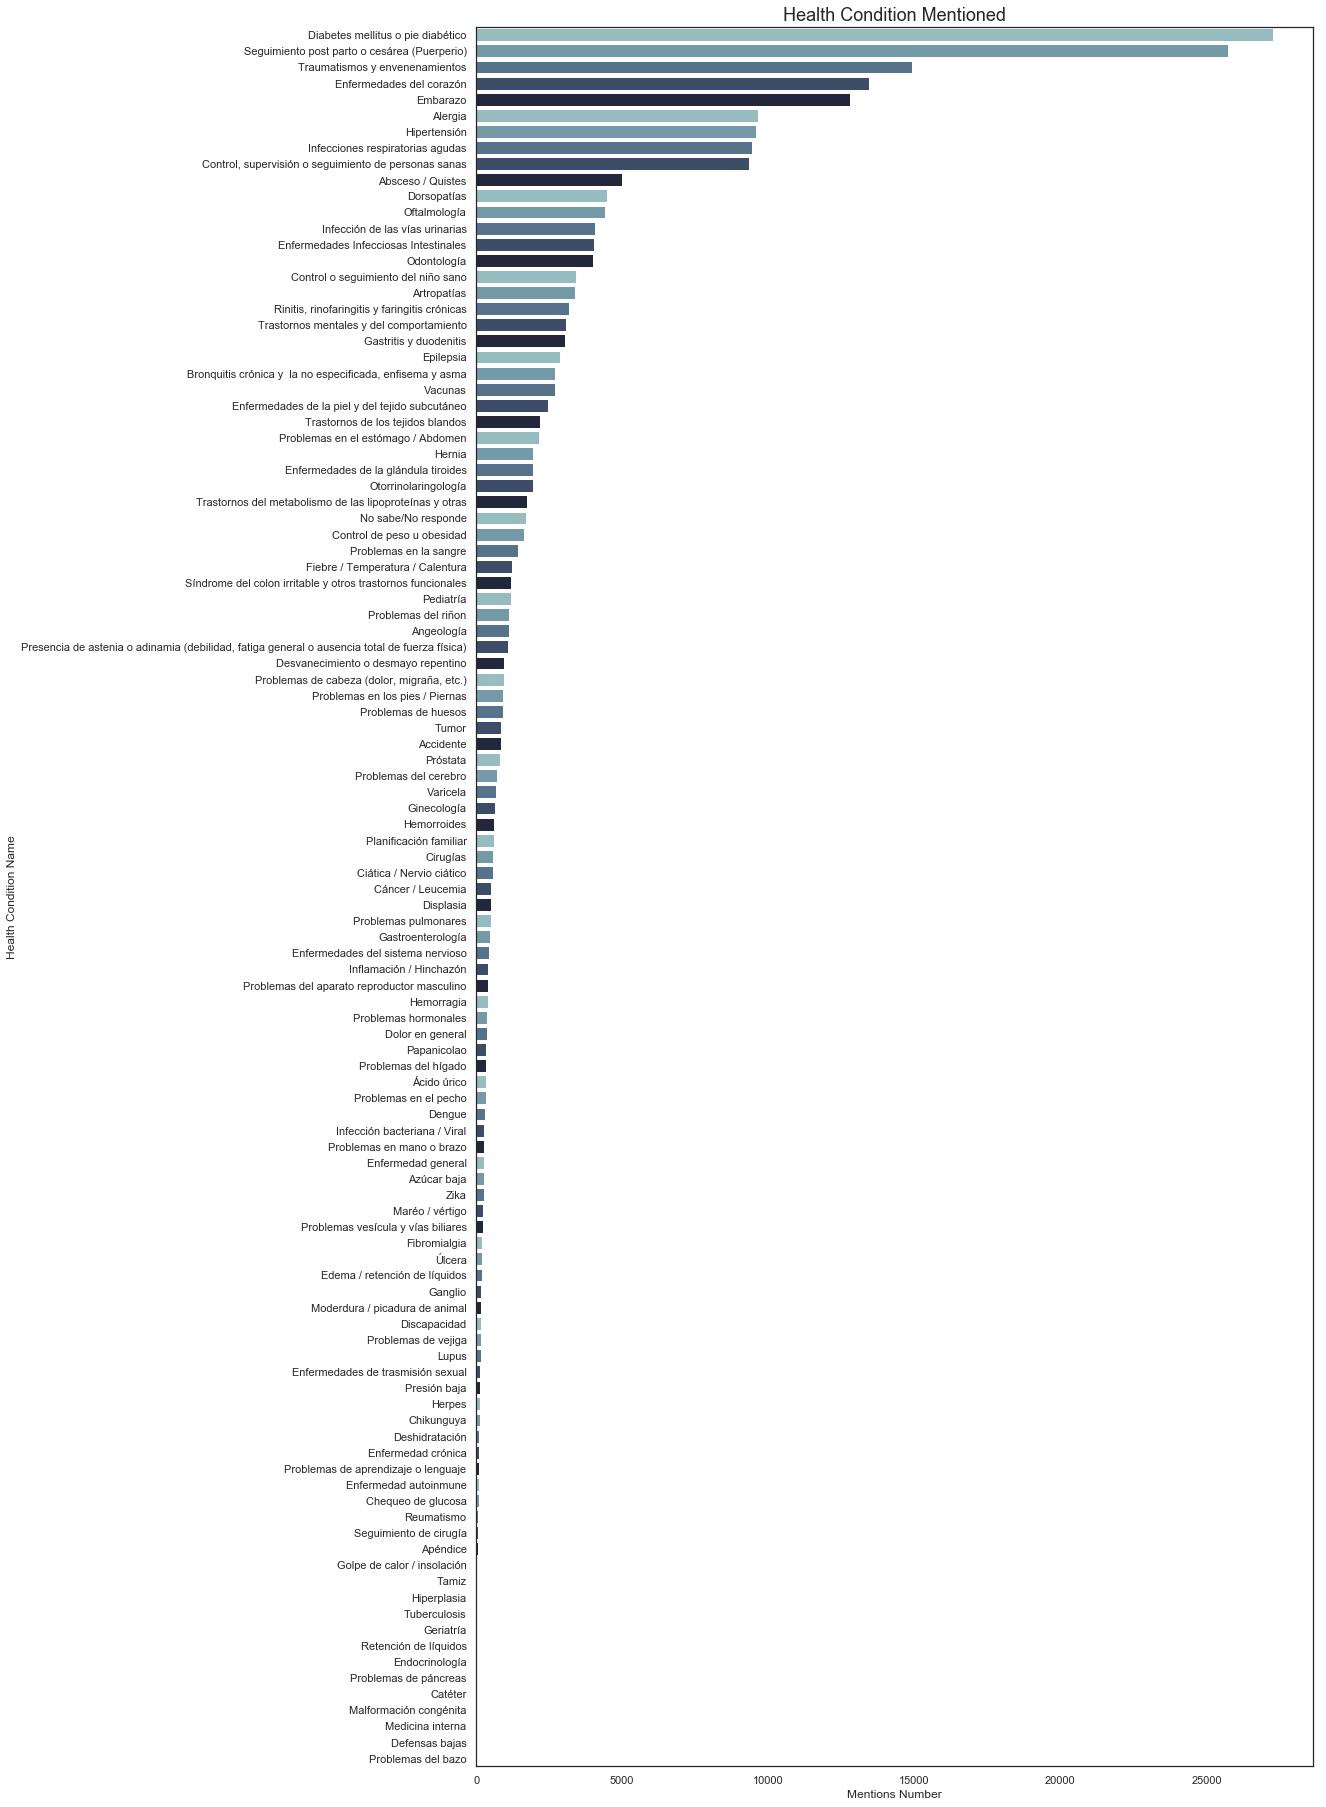

In [203]:
# Build Health Problem Plot

plt.figure(figsize=(15,32))
ax_probl=sns.countplot(y='Probsal_cat',data=df6,order = df6.Probsal_cat.value_counts().index,palette=sns.cubehelix_palette(5, rot=-.25, light=.7))
plt.xlabel('Mentions Number')
plt.ylabel('Health Condition Name')
plt.title('Health Condition Mentioned',fontsize=18)
plt.show()
fig=ax_probl.get_figure()
fig.savefig('DataExploring\\ProblSalud.png',dpi=1200)

* Further studies are required to analyze if the mention of certain Health conditions Increased from one year to another

## Demographics Summary

* Higher percentage of people above 55 years
* 69% women, 31% men
* Elementary and HighSchool prevailing Education level
* Home activities, Private sector workers (no techers),Pensionary/retired, Workers, Freelancers as the prevailing activities
* Diabetes, Postpartum, Trauma/poisoning, Heart Disease, Pregnancy, Alergy, Hipertension, Acure respiratory Infections, Healthy patient supervision. As the most mentioned Health conditions

# Satisfaction Index

* This section shows the satisfaction distribution of the surveys

In [177]:
# Build Satisfaction Data Frame

df_sat=df6[['Date',
           'Entidad',
           'UnidadMed',
           'Fecha_D',
           'Fecha_M',
           'Fecha_A',
           'Servatn_cat',
           'Tipopac_cat',
           'Sat1_ordered',
           'Sat1_cat',
           'Probsal']]

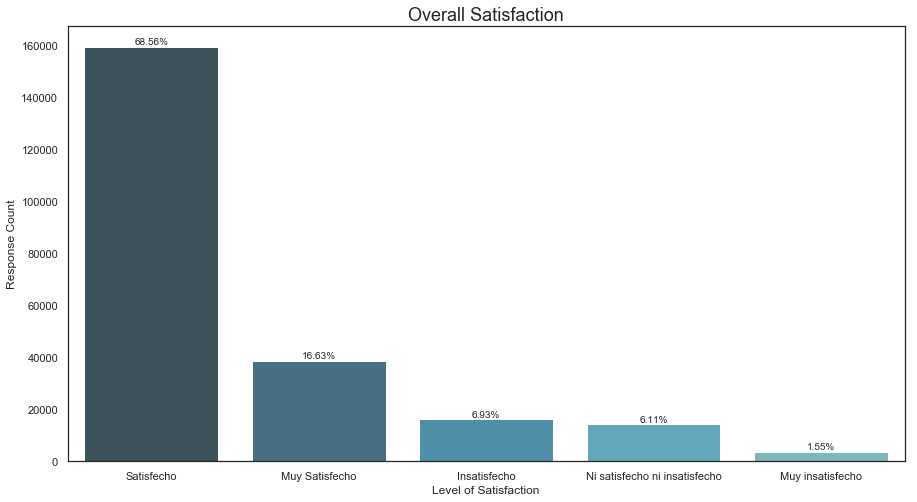

In [178]:
plt.figure(figsize=(15,8))

#build the plot
axOA=sns.countplot(x='Sat1_cat', data=df6,order = df6.Sat1_cat.value_counts().index,palette =sns.color_palette("GnBu_d")) 

plt.xticks(rotation=0)

total = float(len(df6.Sat1_cat)) 

for p in axOA.patches:
        
    height = p.get_height()
    axOA.text(p.get_x()+p.get_width()/2.,height + 1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Overall Satisfaction',fontsize=18)
plt.ylabel('Response Count')
plt.xlabel('Level of Satisfaction')
plt.show()
fig=axOA.get_figure()
fig.savefig('DataExploring\\fig1OverallSatisfaction.png',dpi=1200)

# Satisfaction level by year

### This section shows the comparison between the Satisfaction in 2017 and 2018

In [179]:
# Extract the satisfaction category count for 2017 and 2018

sat_lev_18=df6[df6['Fecha_A']==2018].Sat1_cat.value_counts()
sat_lev_17=df6[df6['Fecha_A']==2017].Sat1_cat.value_counts()

In [180]:
# Build Data frame for satisfaction categories in 2017 and 2018

satLevlbyYear=pd.DataFrame({'2018_count':sat_lev_18,
                           '2017_count':sat_lev_17
                           })

In [181]:
# Create percentage columns for satisfaction categories

satLevlbyYear['2018']=((satLevlbyYear['2018_count']/satLevlbyYear['2018_count'].sum())*100)
satLevlbyYear['2017']=((satLevlbyYear['2017_count']/satLevlbyYear['2017_count'].sum())*100)

In [182]:
# Display data frame

satLevlbyYear

,2017_count,2018_count,2018,2017
Satisfecho,74177,85187,69.450265,67.882898
Muy Satisfecho,17629,21025,17.141017,16.133136
Insatisfecho,8027,8081,6.588184,7.345889
Ni satisfecho ni insatisfecho,7568,6637,5.410936,6.925836
Muy insatisfecho,1871,1729,1.409599,1.712241


In [183]:
# Satisfaction categories data frame reset index inplace

satLevlbyYear.reset_index(inplace=True)

In [184]:
# extract varables of interest

dfsat=satLevlbyYear[['index','2018','2017']]

In [185]:
# put the data in Tidy format

dfsat=pd.melt(dfsat,id_vars=['index'],value_vars=['2018','2017'],var_name='Year',value_name='satisf')

In [186]:
# display data frame in tidy format to graph
dfsat

,index,Year,satisf
0,Satisfecho,2018,69.450265
1,Muy Satisfecho,2018,17.141017
2,Insatisfecho,2018,6.588184
3,Ni satisfecho ni insatisfecho,2018,5.410936
4,Muy insatisfecho,2018,1.409599
5,Satisfecho,2017,67.882898
6,Muy Satisfecho,2017,16.133136
7,Insatisfecho,2017,7.345889
8,Ni satisfecho ni insatisfecho,2017,6.925836
9,Muy insatisfecho,2017,1.712241


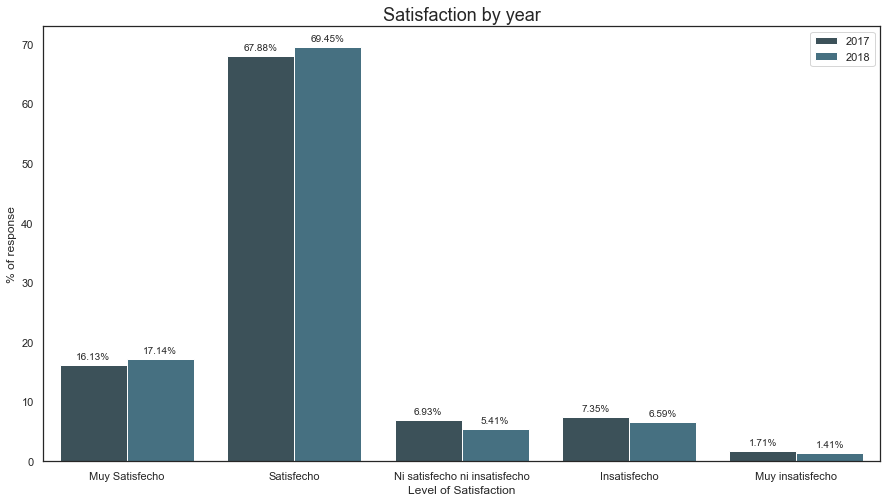

In [187]:
# Build graph to compare satisfaction in 2017 and 2018

plt.figure(figsize=(15,8))

axbyYr=sns.barplot(x="index",
                  y='satisf',
                  hue='Year',
                  data=dfsat,
                  order=['Muy Satisfecho','Satisfecho','Ni satisfecho ni insatisfecho','Insatisfecho','Muy insatisfecho'],
                  palette =sns.color_palette("GnBu_d")
                  )

for p in axbyYr.patches:
        
    height = p.get_height()
    axbyYr.text(p.get_x()+p.get_width()/2.,
                height + 1,
                '{:1.2f}%'.format(height),
                ha="center")
    

legend=plt.legend(shadow=False)
legend.get_frame().set_facecolor('white')
plt.title('Satisfaction by year',fontsize=18)
plt.ylabel('% of response')
plt.xlabel('Level of Satisfaction')
plt.show()
fig=axbyYr.get_figure()
fig.savefig('DataExploring\\fig1Satisfaction17vs18.png',dpi=1200)

# Mean Satisfaction Simulation by Year

* This section runs a random sample simulation to calculate the mean for each year

In [188]:
# extract relevant variables in data frame

dfbyYr=pd.DataFrame(df_sat.groupby(['Entidad','Fecha_A']).Sat1_ordered.mean())

#Tidy format
dfYrSt=dfbyYr.reset_index()

# extract the satisfaction results by year 
avSat17=df_sat[df_sat['Fecha_A']==2017].Sat1_ordered.reset_index(drop=True).dropna()
avSat18=df_sat[df_sat['Fecha_A']==2018].Sat1_ordered.reset_index(drop=True).dropna()

In [218]:
av17=avSat17.mean()

In [219]:
av18=avSat18.mean()

In [221]:
# Punctual estimators of the satisfaction

print(f('Satisfaccion Promedio 2017 {av17}'))
print(f('Satisfaccion Promedio 2018 {av18}'))

Satisfaccion Promedio 2017 3.893787978622154
Satisfaccion Promedio 2018 3.9432491704644583


* As the mean for both years is very close we will perform two test to show if they are really different.
* First we will make simulations of the mean for each year, and we expect that the distributions of the simulations are not overlaped.
* We will perform an statistical test to ensure that the means are different for each year

## Simulations Satisfaction mean Random Samples

In [223]:
# Make 3,000 simulations of 4,000 random samples for each year Satisfaction variable
# Each simulation appends the mean of the sample in a list

avsim17=[]
avsim18=[]

random.seed(500)

for i in range(3000):

        satYrRnd=pd.DataFrame({'2017':sample(list(avSat17),4000),
                               '2018': sample(list(avSat18),4000)
                              })
        
        avsim17.append(satYrRnd['2017'].mean())
        avsim18.append(satYrRnd['2018'].mean())

<Figure size 864x432 with 0 Axes>

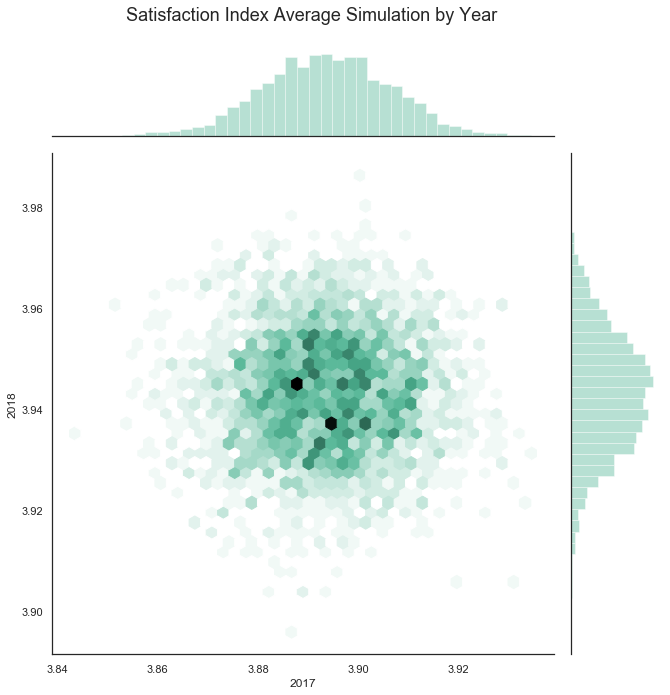

In [190]:
# Plot joint distribution of the mean satisfaction for 2017 vs 2018

plt.figure(figsize=(12,6))

axyr=sns.jointplot(x=avsim17,y=avsim18,kind='hex',color="#4CB391")

axyr.set_axis_labels("2017", "2018")
plt.subplots_adjust(left=1.1, right= 2.5, bottom=.1,top=1.5)
plt.suptitle('Satisfaction Index Average Simulation by Year',x=1.7,y=1.6,fontsize=18)

axyr.savefig('DataExploring\\AverageSat17vs18.png',dpi=1200)

plt.show()

## Statistical test for identical means

### Null hypotesis: the two years have identical satisfaction index average

* We will use the Students-T test for identical means:If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [191]:
sample17=np.array(list(avSat17))

In [192]:
sample18=np.array(list(avSat18))

In [193]:
t2, p2=scipy.stats.ttest_ind(sample17,sample18, equal_var=False)

In [194]:
print("t Statistic = " + str(t2))
print("p-value = " + str(2*p2))

t Statistic = -14.844812531273243
p-value = 1.5868689528533346e-49


* As the p-value is very small we can reject the Null hypothesis.
* This means that actually the satisfaction for each year is statistically different and we can conclude it has grown from 2017 to 2018

# Satisfaction Level by State

* This sections makes a random sample simulation to compute the distribution of the mean satisfaction by State

In [197]:
# Calculates the Overall satisfaction for each state

dfbyState=pd.DataFrame(df_sat.groupby(['Entidad']).Sat1_ordered.mean())
dfbyState.reset_index(inplace=True)
dfbyState.sort_values(by=['Sat1_ordered'],ascending=False,inplace=True)
dfbyState.head()

,Entidad,Sat1_ordered
0,Aguascalientes,3.911780
1,Baja California,4.047844
2,Baja California Sur,4.035744
3,Campeche,3.781414
4,Chiapas,3.994561


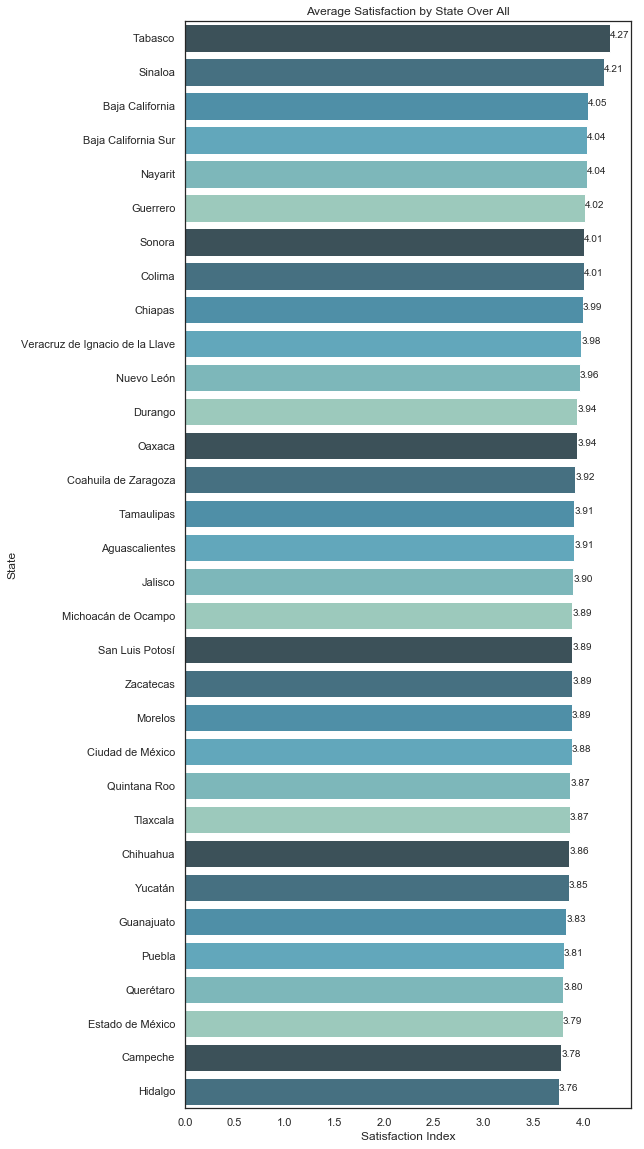

In [199]:
# This is the sample mean for each state withouth random sampling
sns.set_palette("RdBu_r")
plt.figure(figsize=(8,20))
ax_st=sns.barplot(x="Sat1_ordered", 
                  y="Entidad",
                  data=dfbyState,
                  label="Total",
                  palette =sns.color_palette("GnBu_d"))

for p in ax_st.patches:   
    height = p.get_height()
    ax_st.text(p.get_width()+.1, p.get_y() + p.get_height()/2.,
               s='{:1.2f}'.format(p.get_width()),
               ha="center")
    
plt.title('Average Satisfaction by State Over All')
plt.ylabel('State')
plt.xlabel('Satisfaction Index')
plt.show()
fig=ax_st.get_figure()
fig.savefig('DataExploring\\fig1SatisfactionbyState.png',dpi=1200)

In [201]:
# Makes 1000 simulations of 500 random samples for each state for each year

entidades=df_sat.Entidad.unique()

ent=[]
satAvEnt17=[]
satAvEnt18=[]

for entidad in entidades:
    
    datos=df_sat[df['Entidad']==entidad]
    datos17= datos[datos['Fecha_A']==2017].Sat1_ordered.dropna()
    datos18= datos[datos['Fecha_A']==2018].Sat1_ordered.dropna()
    
    for i in range(1000):

        satYrRndEnt=pd.DataFrame({'2017':sample(list(datos17),500),
                                  '2018': sample(list(datos18),500)
                                  })
        
        
        ent.append(entidad)
        satAvEnt17.append(satYrRndEnt['2017'].mean())
        satAvEnt18.append(satYrRndEnt['2018'].mean())
    
dataEnt=pd.DataFrame({'Entidad':ent,
                      'Av17':satAvEnt17,
                      'Av18':satAvEnt18
                     })    
    
    

In [202]:
dataEnt.head()

,Av17,Av18,Entidad
0,3.894,3.918,Aguascalientes
1,3.934,3.872,Aguascalientes
2,3.948,3.896,Aguascalientes
3,3.952,3.932,Aguascalientes
4,3.964,3.866,Aguascalientes


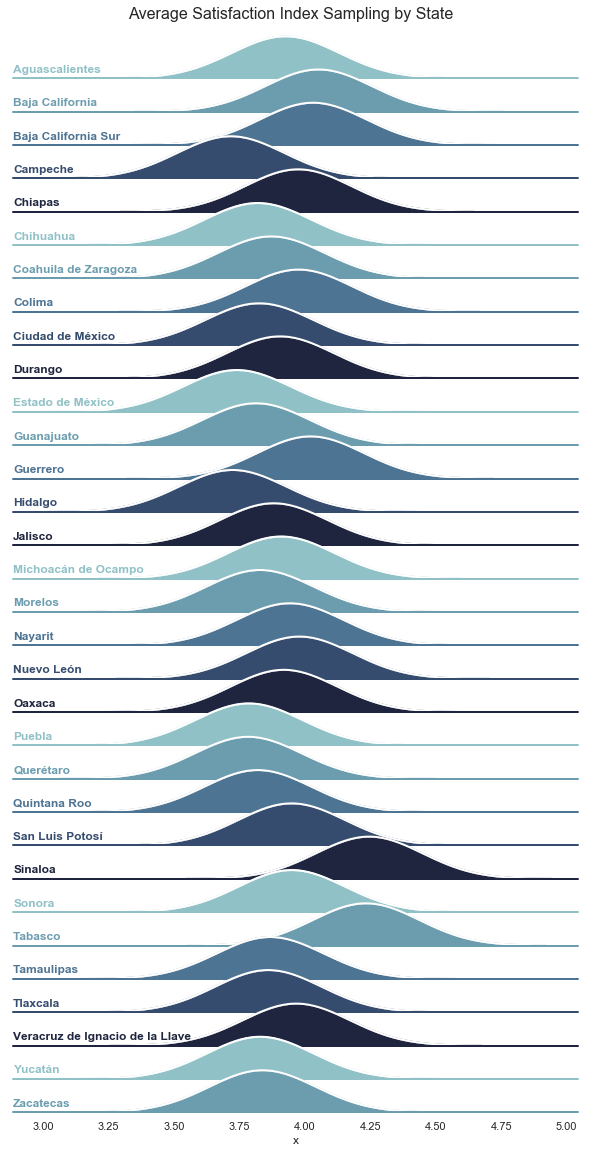

In [46]:
# Overlaping the random samples simulations distribution for each state for the Year 2017

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#Create the data
x = list(dataEnt.Av17)
g = list(dataEnt.Entidad)
df= pd.DataFrame({"x":x,"g":g})
#m = df.g.map(ord)
#df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=17, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Average Satisfaction Index Sampling by State 2017', fontsize=16, y=1)
plt.savefig('DataExploring\overlapStateAvSamples17.png',dpi=1200)
plt.show()

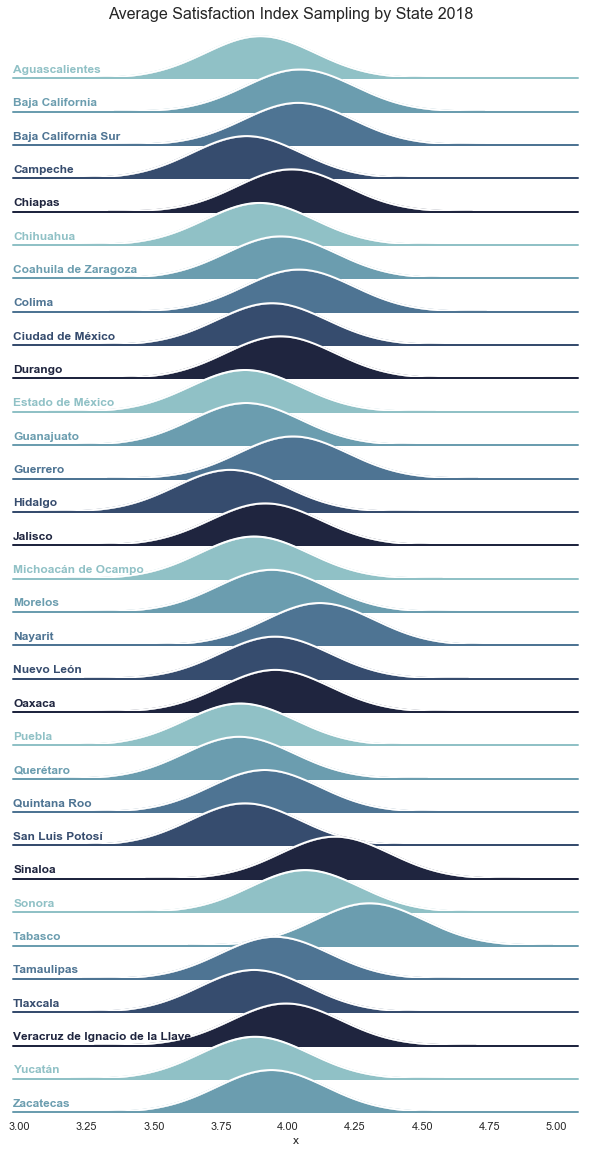

In [204]:
# Overlaping the random samples simulations distribution for each state for the Year 2017

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#Create the data
x = list(dataEnt.Av18)
g = list(dataEnt.Entidad)
df= pd.DataFrame({"x":x,"g":g})
#m = df.g.map(ord)
#df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=17, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Average Satisfaction Index Sampling by State 2018', fontsize=16, y=1)
plt.savefig('DataExploring\overlapStateAvSamples18.png',dpi=1200)
plt.show()

# Satisfaction Correlations

* In this section we will study which are the main satisfaction drivers

In [206]:
# Select variables of interest to measure correlation

df7=df6[['Sat1_ordered',
         'Citapre_ord',
         'Diascita_ord',
         'Hrcita_ord',
         'Tmesphoci_ord',
         'Satiemhoci_ord',
         'Tmedreg2_ord',
         'Satiemesp_ord',
         'Temsad1_ord',
         'Temsad2_ord',
         'Recmedhoy',
         'Filtrofarm2',
         'Totmed_ord',
         'Btratou_ord',
         'Escolar',
         'Calfinmb_F_ord',
         'Edad',
         'Fecha_A',
         'Entidad']]

In [207]:
# Rename the columns with readable names

df8=pd.DataFrame({'Satisfaccion':df7['Sat1_ordered'],
                  'diasParaCita':df7['Diascita_ord'],
                  'citaPrevia':df7['Citapre_ord'],
                  'citaPuntual':df7['Hrcita_ord'],
                  'tiempoEspCitaIndex':df7['Tmesphoci_ord'],
                  'satTmpoEspllegada':df7['Satiemesp_ord'],
                  'tmpoEspLlegIndex':df7['Tmedreg2_ord'],
                  'tmpoEspLabIndex':df7['Temsad1_ord'],
                  'tmpoEspEstudiosIndex':df7['Temsad2_ord'],
                  'encontroMedIndex':df7['Totmed_ord'],
                  'tratoIndex':df7['Btratou_ord'],
                  'limpiezaIndex':df7['Calfinmb_F_ord'],              
                  'Edad':df7['Edad'],
                  'Año':df7['Fecha_A']
                   })

In [208]:
# calculate overall correlations

correlations=df8.corr()

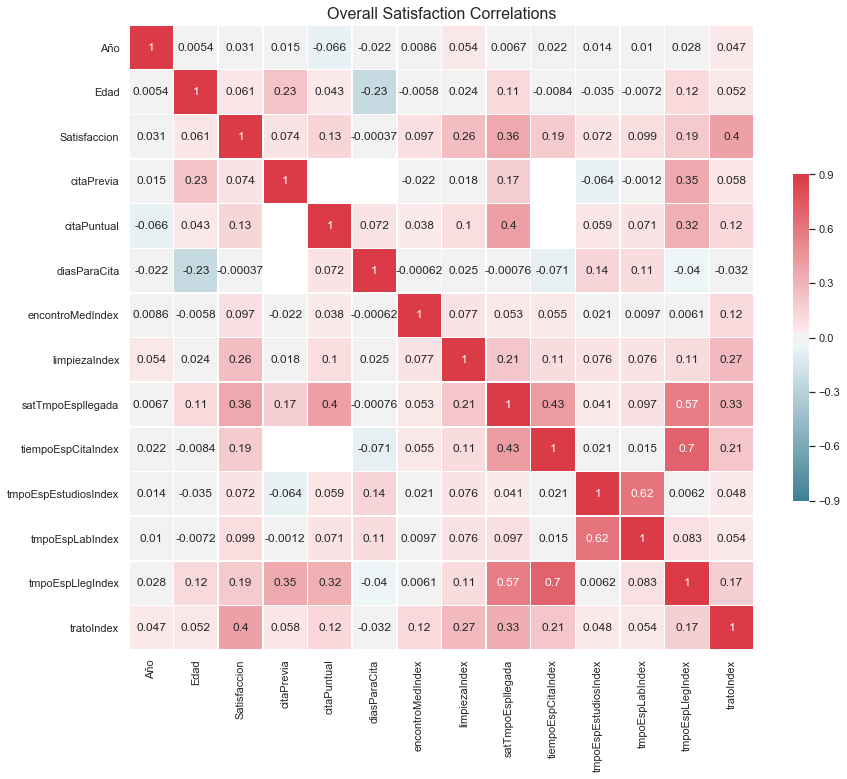

In [209]:
# build correlatiosn heat map

sns.set(style="white")

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Make the figsize 20 x 20
plt.figure(figsize=(14,12))

# Plot heatmap of correlations
ax=sns.heatmap(correlations,annot=True,cmap=cmap, vmax=.9,vmin=-.9, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Overall Satisfaction Correlations',fontsize=16)
plt.savefig('DataExploring\OverallCorrelationsHeatmap.png',dpi=1200)
plt.show()

* Main correlations with Satisfaction are: 'tratoIndex','tmpoEspLlegIndex','limpiezaIndex','tiempoEspCitaIndex'
* This means that the most importat drivers to get a high satisfaction are the Care that the people receive in the clinic, the time they wait  from their arrival, how clean is the institution, and how much time does it take to get an appointment.

In [53]:
correlations18=df8[df8['Año']==2018].corr()

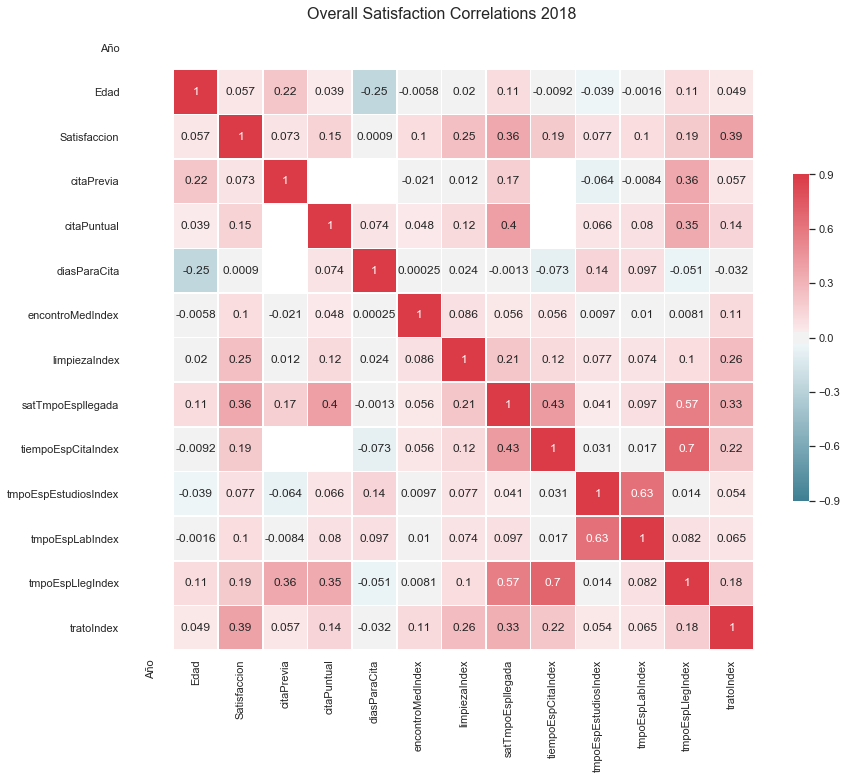

In [54]:
# Correlations for the year  2018
sns.set(style="white")

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Make the figsize 20 x 20
plt.figure(figsize=(14,12))

# Plot heatmap of correlations
ax=sns.heatmap(correlations18,annot=True,cmap=cmap, vmax=.9,vmin=-.9, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Overall Satisfaction Correlations 2018',fontsize=16)

plt.savefig('DataExploring\CorrelationsHeatmap2018.png',dpi=1200)
plt.show()

In [55]:
correlations17=df8[df8['Año']==2017].corr()

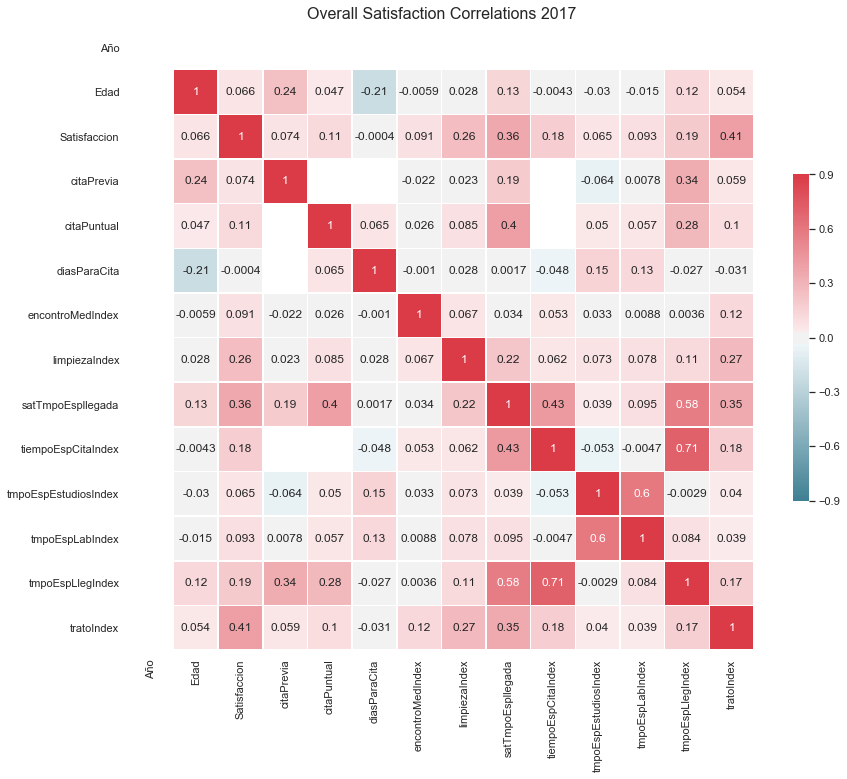

In [56]:
# Correlations for the year  2017

sns.set(style="white")

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Make the figsize 20 x 20
plt.figure(figsize=(14,12))

# Plot heatmap of correlations
ax=sns.heatmap(correlations17,annot=True,cmap=cmap, vmax=.9,vmin=-.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Overall Satisfaction Correlations 2017',fontsize=16)
plt.savefig('DataExploring\CorrelationsHeatmap2017.png',dpi=1200)
plt.show()

In [224]:
# Correlations comparison
corr17vs18=pd.DataFrame({'2017':correlations17['Satisfaccion'],
                         '2018':correlations18['Satisfaccion']
                        })

corr17vs18['Variacion%']=((corr17vs18['2018']-corr17vs18['2017'])/corr17vs18['2017'])*100
corr17vs18.sort_values(by='Variacion%',ascending=False)

,2017,2018,Variacion%
citaPuntual,0.114457,0.150551,31.534893
tmpoEspEstudiosIndex,0.065006,0.077391,19.052458
encontroMedIndex,0.091072,0.101925,11.916228
tmpoEspLabIndex,0.093467,0.103880,11.140543
tiempoEspCitaIndex,0.176125,0.190387,8.097573
Satisfaccion,1.000000,1.000000,0.000000
citaPrevia,0.073612,0.072842,-1.045500
tmpoEspLlegIndex,0.193104,0.190435,-1.382105
satTmpoEspllegada,0.363753,0.355675,-2.220640
limpiezaIndex,0.257708,0.251845,-2.275021


* Although the main drivers to get high satisfaction score are the treat that the people receive, the time they wait from their arrival, how clean is the institution, and how much time does it take to get an appointment, the variables that increase the most to impact the satisfaction index are the "appointment punctuality", "time to get studies results", "Drugs Supply", "time to get lab results"

# Conclusions

### Surveys Demographics

* Higher percentage of people above 55 years
* 69% women, 31% men
* Elementary and HighSchool prevailing Education level
* Home activities, Private sector workers (no techers),Pensionary/retired, Workers, Freelancers as the prevailing activities
* Diabetes, Postpartum, Trauma/poisoning, Heart Disease, Pregnancy, Alergy, Hipertension, Acure respiratory Infections, Healthy patient supervision. As the most mentioned Health conditions

### Satisfaction Increase


* Average Satisfaction 2017: 3.893787978622154
* Average Satisfaction 2018: 3.9432491704644583

* 3,000 simulations of the mean satisfaction for 2017 and 2018 were performed. The Joint distribution of each year mean shows that the 2017 mean interval goes from 3.84 to  around 3.93 , and the 2018 mean interval goes from 3.90 to 4.0. We can se that only an small amount of points of the interval are overlaped which could lead us to think that the means for each year are statistcally different.

* To proof this we performed the two sided T-test to compare identical means of two samples.
* The null hypothesis was that the Mean satisfaction for the  2017 and 2018 are statistically equal.
* The test adresses that as the p-value is smaller (in this case smaller than .01) we can reject the null hypothesis
* For our data the p-value was 1.5868689528533346e-49 , therefore we can reject the null hypothesis and coclude that the means for both years are statistically different.
* With this we have shown that the IMSS Overall Primary Care satisfaction has grown from 2017 to 2018

### Satisfaction by State

* 1,000 simulation for each state were perfomed to analyze if the mean satisfaction by state is different.
* At first sight we can not reject the hypothesis that there are different means by state because the simulations distributions overlap in more than 15% or 20% of the points
* Further Statistical Test are required to proof this

### Satisfaction Key Drivers

* According to the correlations heat map, the key drivers for high Satisfaction are: the Care that the people receive in the clinic, the time they wait  from their arrival, how clean is the institution, and how much time does it take to get an appointment.
* However, we have some drivers that are growing in importance like "appointment punctuality", "time to get studies results", "Drugs Supply", "time to get lab results"
* Further Statistical tests are required to proof this and also we can use machine learning models to find non linear relationships among the variables that impact the Satisfaction